#时间序列预测股票
使用时间序列预测股票，分两部分，第一个使用单变量，后面使用多变量

###环境设置

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib as mpl 
import numpy as np
import os
import pandas as pd
from pathlib import Path

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
root_path = Path('/gdrive/My Drive/data/tuShare')
%cd {root_path}
%ls

/gdrive/My Drive/data/tuShare
close_model.png   model_test.png      stock_basic.csv    ts_code_rows.csv
cov1_model.png    multiple_model.png  stock_company.csv
daily/            namechange.csv      trade_cal.csv
DiYiGe_model.png  ReadMe.gdoc         ts_all_code.csv


#探索数据

所有股票的信息归总在ts_code_rows.csv



In [5]:
code_rows = pd.read_csv(root_path/'ts_code_rows.csv')
code_rows.shape

(3754, 2)

In [6]:
code_rows.head()

,ts_code,rows
0,600689.SH,4000
1,600690.SH,4000
2,600691.SH,4000
3,600692.SH,4000
4,600693.SH,4000


In [7]:
code_rows.describe()

,rows
count,3754.000000
mean,2275.051945
std,1399.546126
min,0.000000
25%,855.500000
50%,2150.000000
75%,4000.000000
max,4000.000000


数据75%以上都有855条记录，也就是说有855个交易日，这样可以用这些数据，每个股票最近855个交易记录作为一条数据来学习

In [8]:
RECORD = 855 #交易记录条数
file_paths = ['daily/{}.csv'.format(code_row) for code_row in code_rows[code_rows['rows']>RECORD]['ts_code']]
file_paths

['daily/600689.SH.csv',
 'daily/600690.SH.csv',
 'daily/600691.SH.csv',
 'daily/600692.SH.csv',
 'daily/600693.SH.csv',
 'daily/600694.SH.csv',
 'daily/600695.SH.csv',
 'daily/600696.SH.csv',
 'daily/600697.SH.csv',
 'daily/600698.SH.csv',
 'daily/600699.SH.csv',
 'daily/600701.SH.csv',
 'daily/600702.SH.csv',
 'daily/600703.SH.csv',
 'daily/600704.SH.csv',
 'daily/600705.SH.csv',
 'daily/600706.SH.csv',
 'daily/600707.SH.csv',
 'daily/600708.SH.csv',
 'daily/600710.SH.csv',
 'daily/600711.SH.csv',
 'daily/600712.SH.csv',
 'daily/600713.SH.csv',
 'daily/600714.SH.csv',
 'daily/600715.SH.csv',
 'daily/600716.SH.csv',
 'daily/600717.SH.csv',
 'daily/600718.SH.csv',
 'daily/600719.SH.csv',
 'daily/600720.SH.csv',
 'daily/600721.SH.csv',
 'daily/600722.SH.csv',
 'daily/600723.SH.csv',
 'daily/600724.SH.csv',
 'daily/600725.SH.csv',
 'daily/600726.SH.csv',
 'daily/600727.SH.csv',
 'daily/600728.SH.csv',
 'daily/600729.SH.csv',
 'daily/600730.SH.csv',
 'daily/600731.SH.csv',
 'daily/600732.S

###查看个股

In [9]:
one_stock = pd.read_csv(root_path/file_paths[0])
one_stock.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600689.SH,20191231,9.64,9.97,9.63,9.80,9.66,0.14,1.4493,38844.72,38199.835
1,600689.SH,20191230,9.52,9.68,9.41,9.66,9.57,0.09,0.9404,17645.70,16899.207
2,600689.SH,20191227,9.68,9.68,9.56,9.57,9.61,-0.04,-0.4162,12860.69,12367.035
3,600689.SH,20191226,9.56,9.65,9.55,9.61,9.54,0.07,0.7338,10453.60,10036.308
4,600689.SH,20191225,9.52,9.63,9.48,9.54,9.52,0.02,0.2101,12995.01,12426.958


In [10]:
one_stock[::-1].head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
3999,600689.SH,20020729,10.87,10.87,10.70,10.84,10.91,-0.07,-0.64,3081.58,3320.278
3998,600689.SH,20020730,10.84,10.89,10.72,10.84,10.84,0.00,0.00,1782.28,1922.997
3997,600689.SH,20020731,10.83,10.89,10.70,10.74,10.84,-0.10,-0.92,2300.58,2477.650
3996,600689.SH,20020801,10.74,10.80,10.60,10.69,10.74,-0.05,-0.47,1711.01,1828.389
3995,600689.SH,20020802,10.68,10.75,10.65,10.70,10.69,0.01,0.09,1308.53,1399.025


In [11]:
one_stock.columns

Index(['ts_code', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount'],
      dtype='object')

In [0]:
#单变量数据
def  gen_univariate_data(file_path,history_size,target_size=1):
  df = pd.read_csv(root_path/file_path)
  start_index = target_size
  end_index = start_index + history_size

  data = df[start_index:end_index][::-1]['close'].values
  #data = df[start_index:end_index][::-1][['trade_date','close']].values
  
  labels = df['close'][:target_size][::-1].values
  #labels = df[['trade_date','close']][:target_size][::-1]

  #修正输出的形状
  data = np.reshape(data,(history_size,1))
  return data,labels 



In [13]:
a,b = gen_univariate_data(root_path/file_paths[0],10,1)
a,b

(array([[9.78],
        [9.72],
        [9.72],
        [9.7 ],
        [9.39],
        [9.52],
        [9.54],
        [9.61],
        [9.57],
        [9.66]]), array([9.8]))

###生成器


In [14]:
import random
#对数据集进行随机打乱
random.shuffle(file_paths)
test_split = int(len(file_paths) * 0.2)#20：80 测试集：训练集
train_file_paths = file_paths[test_split:]
test_file_paths = file_paths[:test_split]
val_split = int(len(train_file_paths)* 0.2) #20:80 验证集：训练集
val_file_paths = train_file_paths[:val_split]
train_file_paths = train_file_paths[val_split:]

print('训练集： {}条'.format( len(train_file_paths)))
print('验证集： {}条'.format( len(val_file_paths)))
print('测试集： {}条'.format( len(test_file_paths)))

训练集： 1802条
验证集： 450条
测试集： 563条


In [0]:
def gen_univariate_train_data(history_size,target_size=1):
  for file_path in train_file_paths:
    yield gen_univariate_data(file_path,history_size,target_size)

def gen_univariate_val_data(history_size,target_size=1):
  for file_path in val_file_paths:
    yield gen_univariate_data(file_path,history_size,target_size)

def gen_univariate_test_data(history_size,target_size=1):
  for file_path in test_file_paths:
    yield gen_univariate_data(file_path,history_size,target_size)




In [0]:
train_data_single = tf.data.Dataset.from_generator(
    gen_univariate_train_data,
    output_types=(tf.float32,tf.float32),
    output_shapes=((10,1),(1,)),
    args=[10,1]
)
val_data_single = tf.data.Dataset.from_generator(
    gen_univariate_val_data,
    output_types=(tf.float32,tf.float32),
    output_shapes=((10,1),(1,)),
    args=[10,1]
)
test_data_single = tf.data.Dataset.from_generator(
    gen_univariate_test_data,
    output_types=(tf.float32,tf.float32),
    output_shapes=((10,1),(1,)),
    args=[10,1]
)


In [17]:
for a,b in train_data_single.take(1):
  print(a)
  print(a.shape)
  print(b)

tf.Tensor(
[[32.41]
 [32.11]
 [32.48]
 [31.89]
 [31.67]
 [31.74]
 [31.38]
 [31.5 ]
 [31.5 ]
 [31.37]], shape=(10, 1), dtype=float32)
(10, 1)
tf.Tensor([31.99], shape=(1,), dtype=float32)


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction','5day Mean']
  marker = ['.-', 'rx', 'go','k+']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i], marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

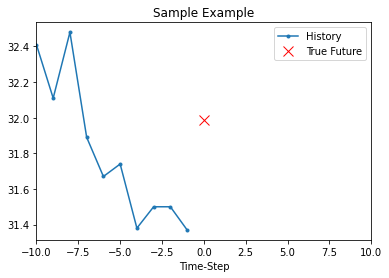

In [19]:
for a,b in train_data_single.take(1):
  show_plot([a,b],0,'Sample Example')

#使用5日均线做为基准对比

In [0]:
def day5mean(history,sing=None):
  if sing is None:
    return np.mean(history[-5:])
  else:
    return np.mean(history[-5:,3])

In [21]:
#查看5日均线2值
for a,b in train_data_single.take(1):
  print('历史：', a)
  print('历史形状：', a.shape)
  print('实际值：', b)
  print('5日均值：',day5mean(a))

历史： tf.Tensor(
[[32.41]
 [32.11]
 [32.48]
 [31.89]
 [31.67]
 [31.74]
 [31.38]
 [31.5 ]
 [31.5 ]
 [31.37]], shape=(10, 1), dtype=float32)
历史形状： (10, 1)
实际值： tf.Tensor([31.99], shape=(1,), dtype=float32)
5日均值： 31.497997


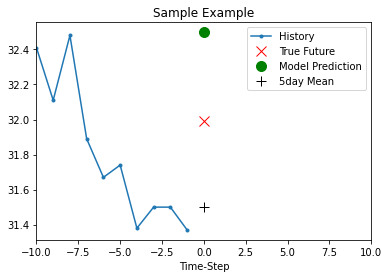

In [22]:
for a,b in train_data_single.take(1):
  
  show_plot([a,b,day5mean(a.numpy())+1,day5mean(a.numpy())],0,'Sample Example')

##构建神经网络(单元素）
只根据历史收盘价预测未来收盘价


In [0]:
BATCH_SIZE = 10
BUFFER_SIZE = 10000

train_data_single = train_data_single.batch(BATCH_SIZE)

val_data_single = val_data_single.batch(BATCH_SIZE)
test_data_single = test_data_single.batch(BATCH_SIZE)

In [0]:
simple_lstm_model = keras.models.Sequential([
  keras.layers.LSTM(21,input_shape=(10,1)),
  tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam',loss='mae')

尝试使用样本进行预测，以便检查模型输出

In [25]:
for x,y in val_data_single.take(1):
  print(simple_lstm_model.predict(x).shape)

(10, 1)


训练模型

In [26]:
fit_history = simple_lstm_model.fit_generator(train_data_single,
                                              epochs=10,
                                              validation_data=val_data_single,
                                              validation_steps=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
181/181 [==============================] - 1011s 6s/step - loss: 7.6167 - val_loss: 3.1724
Epoch 2/10
181/181 [==============================] - 15s 81ms/step - loss: 4.7849 - val_loss: 1.8513
Epoch 3/10
181/181 [==============================] - 15s 82ms/step - loss: 3.9820 - val_loss: 1.3003
Epoch 4/10
181/181 [==============================] - 14s 80ms/step - loss: 3.5591 - val_loss: 1.0602
Epoch 5/10
181/181 [==============================] - 15s 81ms/step - loss: 3.2786 - val_loss: 0.8768
Epoch 6/10
181/181 [==============================] - 15s 81ms/step - loss: 3.0864 - val_loss: 0.7424
Epoch 7/10
181/181 [==============================] - 15s 81ms/step - loss: 2.9364 - val_loss: 0.6632
Epoch 8/10
181/181 [==============================] - 15s 82ms/step - loss: 2.8034 - val_loss: 0.6183
Epoch 9/10
181/181 [==============================] - 15s 81ms/step - loss: 2.6863 - val_loss: 0.5612
Epoch 

实际值： tf.Tensor(
[[ 4.17]
 [ 6.81]
 [11.08]
 [ 4.36]
 [22.5 ]
 [ 3.36]
 [ 3.  ]
 [ 2.41]
 [ 7.14]
 [ 9.52]], shape=(10, 1), dtype=float32)
预测值: [[ 4.1856775]
 [ 6.8771973]
 [11.104818 ]
 [ 4.431199 ]
 [21.366108 ]
 [ 3.3857594]
 [ 3.026836 ]
 [ 2.368371 ]
 [ 7.1277294]
 [ 9.444375 ]]
实际值： 4.17, 预测值： 4.19, 5日值： 4.13，  差值： 0.02, 5日差值： -0.04， 差比： 0.0038,  5日差比： -0.0086  效果比5日好：0.02
实际值： 6.81, 预测值： 6.88, 5日值： 7.00，  差值： 0.07, 5日差值： 0.19， 差比： 0.0099,  5日差比： 0.0273  效果比5日好：0.12
实际值： 11.08, 预测值： 11.10, 5日值： 11.28，  差值： 0.02, 5日差值： 0.20， 差比： 0.0022,  5日差比： 0.0184  效果比5日好：0.18
实际值： 4.36, 预测值： 4.43, 5日值： 4.23，  差值： 0.07, 5日差值： -0.13， 差比： 0.0163,  5日差比： -0.0298  效果比5日好：0.06
实际值： 22.50, 预测值： 21.37, 5日值： 22.53，  差值： -1.13, 5日差值： 0.03， 差比： -0.0504,  5日差比： 0.0015  效果比5日好：1.10
实际值： 3.36, 预测值： 3.39, 5日值： 3.44，  差值： 0.03, 5日差值： 0.08， 差比： 0.0077,  5日差比： 0.0232  效果比5日好：0.05
实际值： 3.00, 预测值： 3.03, 5日值： 3.02，  差值： 0.03, 5日差值： 0.02， 差比： 0.0089,  5日差比： 0.0053  效果比5日好：0.01
实际值： 2.41, 预测值： 2.37, 5日值： 2.36，  差值： -

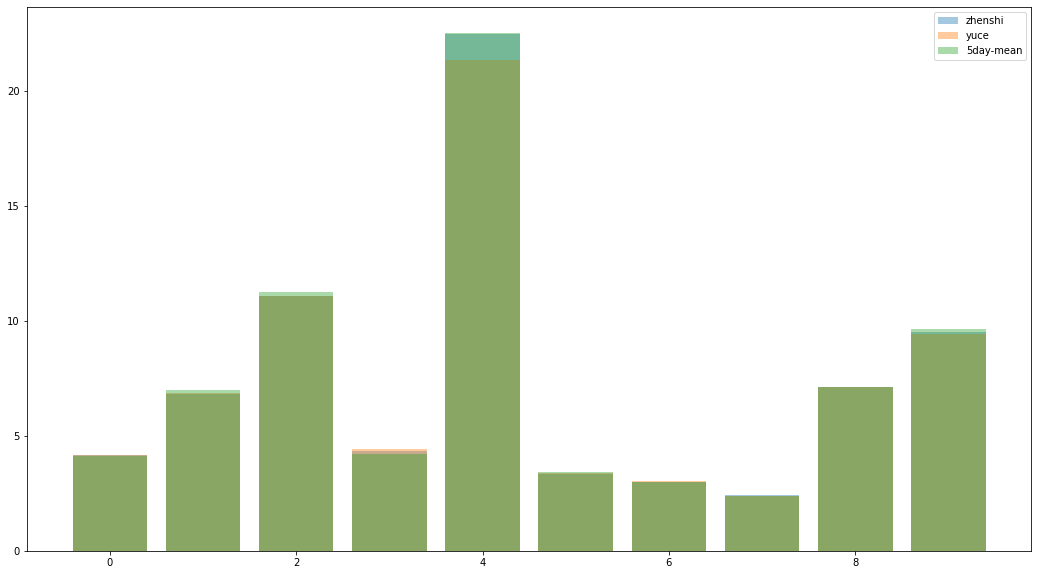

In [27]:
#测试一下模型的预测效果
for x,y in test_data_single.take(1):
  p = simple_lstm_model.predict(x)
  print('实际值：',y)
  print('预测值:',p)
  day5 = [day5mean(x_) for x_ in x ]
  for i in range(len(x)):
    Y = y[i][0]
    P = p[i][0]
    d5 = day5[i]

    print("实际值： {:.2f}, 预测值： {:.2f}, 5日值： {:.2f}，  差值： {:.2f}, 5日差值： {:.2f}， 差比： {:.4f},  5日差比： {:.4f}  效果比5日好：{:.2f}".format(
        Y, P, d5, P-Y, d5-Y, (P-Y)/Y, (d5-Y)/Y, abs(abs(P-Y)- abs(d5-Y))
    ))
    #print("实际值： {}, 预测值： {}, 5日值： {}，  差值： {}, 5日差值： {}， 差比： {},  5日差比： {:.4f}  ".format(
    #    y[i], p[i], day5[i], p[i]-y[i], day5[i]-y[i], (p[i]-y[i])/y[i], (day5[i]-y[i])/y[i]
    #))
  plt.figure(figsize=(18,10))
  plt.bar(range(len(y)),y[:,0],label='zhenshi',alpha=0.4)
  plt.bar(range(len(p)),p[:,0],label='yuce',alpha=0.4)
  plt.bar(range(len(p)),day5 ,label='5day-mean',alpha=0.4)
  #plt.plot(range(len(p)),p-y,label='chaju')
  #plt.plot(range(len(p)),(p-y)/y,label='chaju-per')
  plt.legend()

真实值：4.17, 预测值： 4.19 五日值：4.24,
 预测绝对差-五日绝对差:-0.05


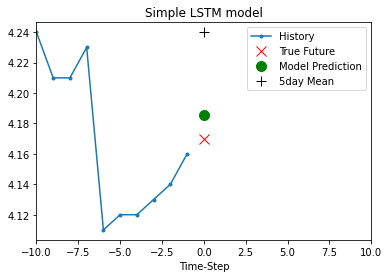

真实值：11.18, 预测值： 11.12 五日值：11.28,
 预测绝对差-五日绝对差:-0.04


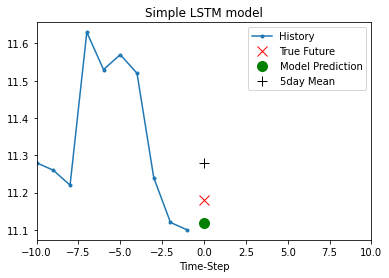

真实值：6.04, 预测值： 6.06 五日值：7.09,
 预测绝对差-五日绝对差:-1.03


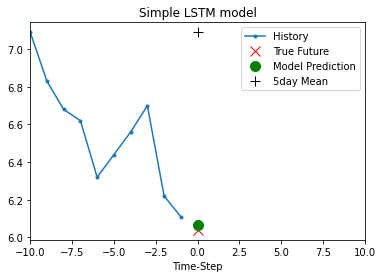

In [28]:
#画出来走势图看预测值
for x,y in test_data_single.take(3):
  p = simple_lstm_model.predict(x)
  d5 = day5mean(x.numpy()[0][0])
  print('真实值：{:.2f}, 预测值： {:.2f} 五日值：{:.2f},\n 预测绝对差-五日绝对差:{:.2f}'.format(
      y.numpy()[0][0],p[0][0],d5,
      abs(p[0][0]-y.numpy()[0][0])-abs(d5-y.numpy()[0][0])
  ))
  #print('X:',x)
  #print('Y:',y)
  #print('D5:',d5)
  plot = show_plot([x[0].numpy(),y[0].numpy(),
                    p[0],
                    d5],
                   0,'Simple LSTM model')
  plot.show()

看看测试值是多少：

In [29]:
test_result = simple_lstm_model.evaluate_generator(test_data_single)
print(test_result)

Instructions for updating:
Please use Model.evaluate, which supports generators.
1.917300907666223


看起来好像5日均线预测值好一些预测好一些

#预测多元时间序列(根据多个数据指标预测）
将加入开盘，收盘，最高，最低，涨跌，涨跌幅，成交量，成交额等。

先看一下单个股票拥有的数据

In [30]:
one_stock.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600689.SH,20191231,9.64,9.97,9.63,9.80,9.66,0.14,1.4493,38844.72,38199.835
1,600689.SH,20191230,9.52,9.68,9.41,9.66,9.57,0.09,0.9404,17645.70,16899.207
2,600689.SH,20191227,9.68,9.68,9.56,9.57,9.61,-0.04,-0.4162,12860.69,12367.035
3,600689.SH,20191226,9.56,9.65,9.55,9.61,9.54,0.07,0.7338,10453.60,10036.308
4,600689.SH,20191225,9.52,9.63,9.48,9.54,9.52,0.02,0.2101,12995.01,12426.958


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f47603f76a0>,
      dtype=object)

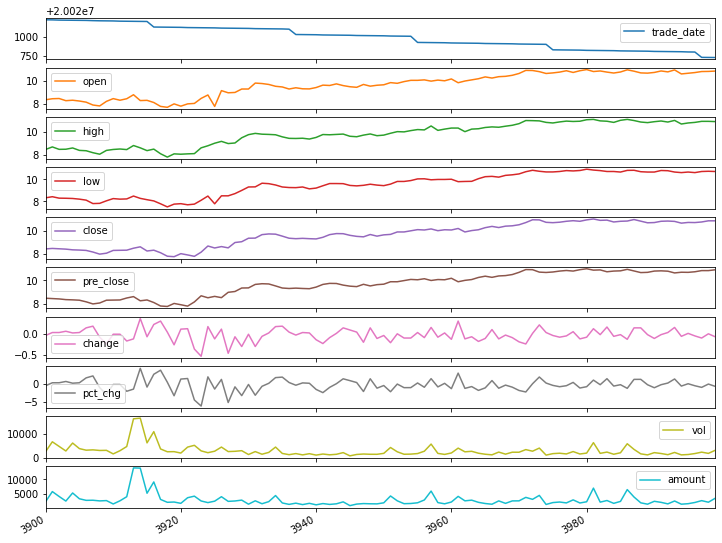

In [31]:
one_stock[-100:].plot(subplots=True,figsize=(12,10))

###生成多元数据

In [0]:
#多变量数据
def  gen_multivariate_data(file_path,history_size,target_size=1):
  df = pd.read_csv(root_path/file_path)
  start_index = target_size
  end_index = start_index + history_size

  data = df[start_index:end_index][::-1]
  data.pop('ts_code')
  data.pop('trade_date')
  #使用训练数据(成交量和成交金额)的均值和标准差对数据集进行标准化。
  for col in ['vol','amount']:
    #mean = data[col].mean(axis=0)
    #std = data[col].mean(axis=0)
    data[col] = (data[col] - data[col].mean(axis=0))/data[col].mean(axis=0)

  labels = df['close'][:target_size][::-1].values
  #labels = df[['trade_date','close']][:target_size][::-1]
  
  #修正输出的形状
  #data = np.reshape(data,(history_size,1))
  return np.array(data),labels 
  #return data,labels 



In [33]:
#查看5日均线值
 a,b = gen_multivariate_data(root_path/file_paths[0],10,1)
print('历史：', a)
print('历史形状：', a.shape)
print('实际值：', b)
print('5日均值：',day5mean(a,False))

历史： [[ 4.26        4.27        4.17        4.24        4.24        0.
   0.          1.26896576  1.29271916]
 [ 4.24        4.27        4.2         4.21        4.24       -0.03
  -0.7075      0.04192172  0.05454571]
 [ 4.21        4.22        4.18        4.21        4.21        0.
   0.         -0.27458223 -0.27019371]
 [ 4.23        4.25        4.2         4.23        4.21        0.02
   0.4751     -0.13652884 -0.12686477]
 [ 4.21        4.23        4.1         4.11        4.23       -0.12
  -2.8369      0.32607648  0.32051613]
 [ 4.13        4.15        4.1         4.12        4.11        0.01
   0.2433     -0.22568408 -0.23571098]
 [ 4.11        4.14        4.1         4.12        4.12        0.
   0.         -0.22798002 -0.24000236]
 [ 4.12        4.14        4.11        4.13        4.12        0.01
   0.2427     -0.47296186 -0.47953697]
 [ 4.14        4.16        4.13        4.14        4.13        0.01
   0.2421     -0.35430587 -0.35958075]
 [ 4.14        4.17        4.03        

In [34]:
a,b = gen_multivariate_data(root_path/file_paths[0],10,1)
a,b

(array([[ 4.26      ,  4.27      ,  4.17      ,  4.24      ,  4.24      ,
          0.        ,  0.        ,  1.26896576,  1.29271916],
        [ 4.24      ,  4.27      ,  4.2       ,  4.21      ,  4.24      ,
         -0.03      , -0.7075    ,  0.04192172,  0.05454571],
        [ 4.21      ,  4.22      ,  4.18      ,  4.21      ,  4.21      ,
          0.        ,  0.        , -0.27458223, -0.27019371],
        [ 4.23      ,  4.25      ,  4.2       ,  4.23      ,  4.21      ,
          0.02      ,  0.4751    , -0.13652884, -0.12686477],
        [ 4.21      ,  4.23      ,  4.1       ,  4.11      ,  4.23      ,
         -0.12      , -2.8369    ,  0.32607648,  0.32051613],
        [ 4.13      ,  4.15      ,  4.1       ,  4.12      ,  4.11      ,
          0.01      ,  0.2433    , -0.22568408, -0.23571098],
        [ 4.11      ,  4.14      ,  4.1       ,  4.12      ,  4.12      ,
          0.        ,  0.        , -0.22798002, -0.24000236],
        [ 4.12      ,  4.14      ,  4.11      , 

In [0]:
def gen_multivariate_train_data(history_size,target_size=1):
  for file_path in train_file_paths:
    yield gen_multivariate_data(file_path,history_size,target_size)

def gen_multivariate_val_data(history_size,target_size=1):
  for file_path in val_file_paths:
    yield gen_multivariate_data(file_path,history_size,target_size)

def gen_multivariate_test_data(history_size,target_size=1):
  for file_path in test_file_paths:
    yield gen_multivariate_data(file_path,history_size,target_size)


In [36]:
a,b = next(iter(gen_multivariate_train_data(10,1)))
print('a:',a)
print('a.shape:',a.shape)
print('b:',b)

a: [[31.6        32.67       31.51       32.41       31.6         0.81
   2.5633      0.619786    0.63980341]
 [32.36       32.51       32.         32.11       32.41       -0.3
  -0.9256      0.0794315   0.09035769]
 [32.01       32.65       32.01       32.48       32.11        0.37
   1.1523     -0.07559036 -0.06036298]
 [32.6        32.95       31.79       31.89       32.48       -0.59
  -1.8165      0.14835787  0.16008621]
 [32.         32.3        31.65       31.67       31.89       -0.22
  -0.6899     -0.16688598 -0.16454144]
 [31.69       31.94       31.36       31.74       31.67        0.07
   0.221      -0.24911173 -0.25592698]
 [31.76       31.79       31.21       31.38       31.74       -0.36
  -1.1342     -0.08731522 -0.09933009]
 [31.4        31.75       31.15       31.5        31.38        0.12
   0.3824     -0.21237134 -0.22423886]
 [31.52       31.86       31.3        31.5        31.5         0.
   0.          0.08507161  0.07714415]
 [31.45       31.45       30.56      

In [0]:
train_data_multe = tf.data.Dataset.from_generator(gen_multivariate_train_data,
                                                  output_types=(tf.float32,tf.float32),
                                                  output_shapes=((100,9),(1,)),
                                                  args=[100,1])
train_data_multe = train_data_multe.batch(10)
val_data_multe = tf.data.Dataset.from_generator(gen_multivariate_val_data,
                                                  output_types=(tf.float32,tf.float32),
                                                  output_shapes=((100,9),(1,)),
                                                  args=[100,1])
val_data_multe = val_data_multe.batch(10)
test_data_multe = tf.data.Dataset.from_generator(gen_multivariate_test_data,
                                                  output_types=(tf.float32,tf.float32),
                                                  output_shapes=((100,9),(1,)),
                                                  args=[100,1])
test_data_multe = test_data_multe.batch(10)

In [38]:
for x,y in train_data_multe.take(1):
  #print('x:',x)
  print('x.shape:',x.shape)
  print('y:',y)

x.shape: (10, 100, 9)
y: tf.Tensor(
[[31.99]
 [15.46]
 [ 8.16]
 [ 6.76]
 [ 4.4 ]
 [16.13]
 [ 6.15]
 [ 3.67]
 [ 7.01]
 [14.99]], shape=(10, 1), dtype=float32)


构建多元模型

In [0]:
#Multiple
multiple_model = keras.models.Sequential([
  keras.layers.LSTM(7,
                    return_sequences=True,
                    input_shape=(100,9)),
  #keras.layers.LSTM(40,return_sequences=True,activation='relu'),
  #keras.layers.Dropout(0.2),
  keras.layers.LSTM(5,activation='relu'),  
  keras.layers.Dense(3, activation='relu'),
  #keras.layers.SimpleRNN(10,activation='tanh'),
  #keras.layers.Dropout(0.2),
  keras.layers.Dense(1)
])


#multiple_model.compile(optimizer=keras.optimizers.Adam(),loss='mae')
multiple_model.compile(optimizer=keras.optimizers.RMSprop(),loss='mae')

In [40]:
multiple_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 7)            476       
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 260       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 758
Trainable params: 758
Non-trainable params: 0
_________________________________________________________________


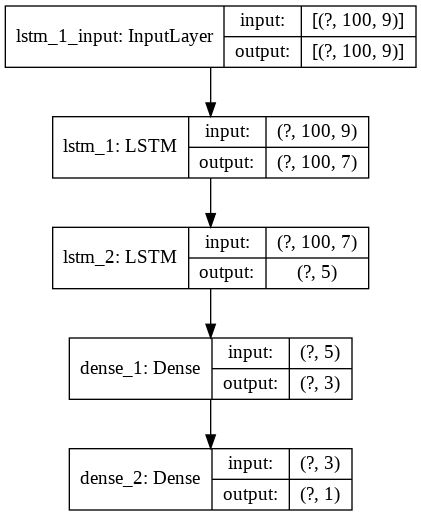

In [41]:
keras.utils.plot_model(multiple_model,'multiple_model.png',show_shapes=True)

先看一下预测出来的模型是什么样的

In [42]:
for x,y in test_data_multe.take(1):
  print(multiple_model.predict(x).shape)

(10, 1)


In [43]:
multiple_history = multiple_model.fit_generator(
    train_data_multe,epochs=10,
    validation_data=val_data_multe,
    validation_steps=5
)

Epoch 1/10
181/181 [==============================] - 29s 158ms/step - loss: 8.0035 - val_loss: 3.2410
Epoch 2/10
181/181 [==============================] - 26s 145ms/step - loss: 5.3611 - val_loss: 2.4796
Epoch 3/10
181/181 [==============================] - 27s 148ms/step - loss: 4.6647 - val_loss: 1.5198
Epoch 4/10
181/181 [==============================] - 26s 145ms/step - loss: 4.3209 - val_loss: 1.6792
Epoch 5/10
181/181 [==============================] - 26s 144ms/step - loss: 4.0645 - val_loss: 1.6144
Epoch 6/10
181/181 [==============================] - 26s 142ms/step - loss: 3.8417 - val_loss: 1.5875
Epoch 7/10
181/181 [==============================] - 25s 139ms/step - loss: 3.6460 - val_loss: 1.0717
Epoch 8/10
181/181 [==============================] - 25s 140ms/step - loss: 3.3175 - val_loss: 1.3635
Epoch 9/10
181/181 [==============================] - 25s 140ms/step - loss: 3.1534 - val_loss: 0.7796
Epoch 10/10
181/181 [==============================] - 25s 139ms/step - l

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

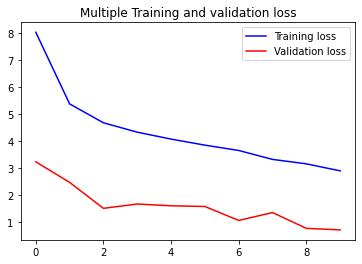

In [45]:
plot_train_history(multiple_history,'Multiple Training and validation loss')

###预测未来的一步
现在已经对模型进行了训练，让我们进行一些样本预测。为模型提供了过去五天内每小时采样的三个特征的历史记录（120个数据点），因为目标是预测温度，所以该图仅显示过去的温度。预测是在未来一天进行的（因此，历史记录和预测之间存在差距）。

真实值：4.17, 预测值： 4.26 五日值：4.15,
 预测绝对差-五日绝对差:0.08


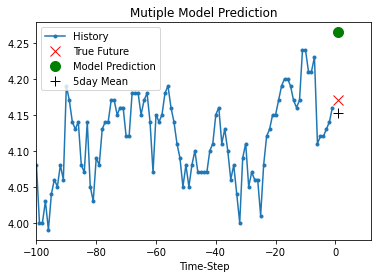

真实值：11.18, 预测值： 11.93 五日值：11.47,
 预测绝对差-五日绝对差:0.46


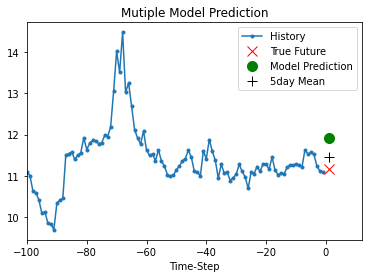

真实值：6.04, 预测值： 6.38 五日值：6.59,
 预测绝对差-五日绝对差:-0.21


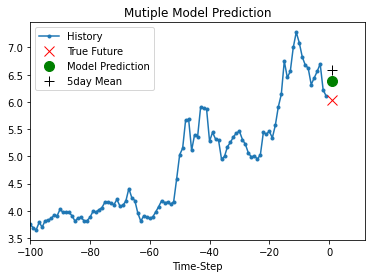

真实值：12.19, 预测值： 12.56 五日值：12.08,
 预测绝对差-五日绝对差:0.26


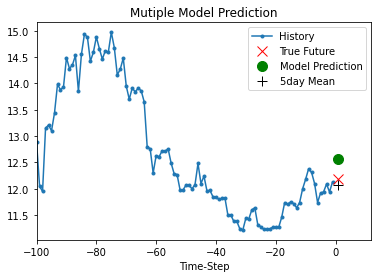

真实值：14.60, 预测值： 16.73 五日值：14.99,
 预测绝对差-五日绝对差:1.74


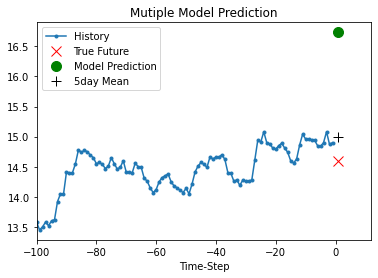

In [46]:
for x,y in test_data_multe.take(5):
  p = multiple_model.predict(x)
  d5 = day5mean(x[0][:,1].numpy())
  print('真实值：{:.2f}, 预测值： {:.2f} 五日值：{:.2f},\n 预测绝对差-五日绝对差:{:.2f}'.format(
      y.numpy()[0][0],p[0][0],d5,
      abs(p[0][0]-y.numpy()[0][0])-abs(d5-y.numpy()[0][0])
  ))
  #print('Y:',y.numpy()[0])
  #print('P:',p[0])
  #print('D5:',d5)
  plot = show_plot([x[0][:,3].numpy(),y[0].numpy(),
                    p[0],
                    d5],
                   1,
                   'Mutiple Model Prediction')
  plot.show()